In [1]:
!pip install fuzzywuzzy
!pip install parfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for parfit: filename=parfit-0.220-py3-none-any.whl size=8660 sha256=771227207846cbc0c667d14b796f4830fa61a2e91b1de6c68c3eb2e111ae33e4
  Stored in directory: /root/.cache/pip/wheels/9a/3b/19/64addee68f796a7e7108c2658a8765d600753bc728e7beb55e
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=41099794c1fd72c548e564fc4be3a8a836f042abe795ac67916dc9df8fc2e9b3
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built parfit sklearn


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import json

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import string
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz


from ast import literal_eval
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, log_loss
from scipy.spatial import distance

import parfit.parfit as pf
from sklearn.feature_extraction.text import TfidfVectorizer

import ast
from difflib import SequenceMatcher
from sklearn.utils import shuffle

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/"

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Mounted at /content/drive


In [3]:
def clean_text(q):

    q = str(q).lower().strip()
    
    # Replace special characters with their string equivalents.
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears many times in the whole dataset.
    #q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words -  https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    contractions = { "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "can not have", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
    "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as",
    "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have" }

    qs_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        qs_decontracted.append(word)

    q = ' '.join(qs_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    q = q.replace(" e g ", " eg ")
    q = q.replace(" b g ", " bg ")
    q = q.replace(" u s ", " american ")
    q = q.replace("e - mail", "email")
    q = q.replace("j k", "jk")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()      
    return(q)

def common_words(x):
    return len(set(x[0]) & set(x[1]))


def postags(sentence):
  #lowercase case and convert to string type
  x = str.lower(str(sentence))

  #add space between numbers and text
  x = re.sub('(\d+(\.\d+)?)', r' \1 ', x).strip()

  #remove non ascii characters
  x = x.encode('ascii',errors='ignore').decode('ascii')

  #clean text
  x = clean_text(x)
  
  # tokenize, remove punctuation & convert to lowercase
  tokens = nltk.word_tokenize(x)
  tokens = list(filter(lambda token: token not in string.punctuation, tokens))
    
  # find and return POS tag for each token
  return nltk.pos_tag(tokens)
  

def lemmatize(postags):
  
  lemmatizer = WordNetLemmatizer()

  lemmatized_tokens = []
  for word, tag in postags:
    #J Adjective, V - Verb, N - Noun, R - Adverb
    if tag[0] in ['A', 'V', 'N', 'R']:
      lemmatized_tokens.append(lemmatizer.lemmatize(word, str.lower(tag[0])))
    else:
      lemmatized_tokens.append(word)
  return lemmatized_tokens

def same_question(x):
  questions = ['what', 'when', 'who', 'which', 'why', 'how', 'where', 'whose','whom']
  same_type = False
  for question in questions:
    if (len(set(x[0]) & set([question])) > 0) & (len(set(x[1]) & set([question])) > 0):
        same_type = True
        break
  return int(same_type)

#returns number of specified tags in word list
def tag_count(pos_tags, tag):
  count = 0
  for word, ptag in pos_tags:
    if ptag[0] == str.upper(tag):
        count +=1
  return count

def percentshared(x):
  return x[2]/max(x[0],x[1])

def add_postags(getdf):
  #tags
  getdf['q1tags'] = getdf['question1'].apply(postags)
  getdf['q2tags'] = getdf['question2'].apply(postags)
  return getdf

def add_tokens(getdf):
  #tokens
  getdf['q1tokens'] = getdf['q1tags'].apply(lemmatize)
  getdf['q2tokens'] = getdf['q2tags'].apply(lemmatize)
  return getdf

def add_otherfeatures(getdf):
  #length of questions
  getdf['q1lens'] = getdf['q1tokens'].apply(lambda x: len(x))
  getdf['q2lens'] = getdf['q2tokens'].apply(lambda x: len(x))

  #number of common words
  getdf['commonwords'] = getdf[['q1tokens','q2tokens']].apply(lambda x: common_words(x), axis = 1)
  
  #same type of question
  getdf['samequestion'] = getdf[['q1tokens','q2tokens']].apply(lambda x: same_question(x), axis = 1)
  
  #% shared words
  getdf['%commonwords'] = getdf[['q1lens','q2lens','commonwords']].apply(lambda x: percentshared(x), axis = 1)
  
  #J Adjective, V - Verb, N - Noun, R - Adverb
  #tag count - Verbs
  getdf['q1_verb_count'] = getdf['q1tags'].apply(tag_count, args = ['V'])
  getdf['q2_verb_count'] = getdf['q2tags'].apply(tag_count, args = ['V'])

  #tag count - Nouns
  getdf['q1_noun_count'] = getdf['q1tags'].apply(tag_count, args = ['N'])
  getdf['q2_noun_count'] = getdf['q2tags'].apply(tag_count, args = ['N'])

  #tag count - Adjective
  getdf['q1_adj_count'] = getdf['q1tags'].apply(tag_count, args = ['J'])
  getdf['q2_adj_count'] = getdf['q2tags'].apply(tag_count, args = ['J'])

  #tag count - Adverb
  getdf['q1_adv_count'] = getdf['q1tags'].apply(tag_count, args = ['R'])
  getdf['q2_adv_count'] = getdf['q2tags'].apply(tag_count, args = ['R'])
  return getdf

def token_to_sentence(tokens):
  #tokens read as string from csv, convert back to list using ast package
  tokens = literal_eval(str(tokens))
  sentence = ''
  for token in tokens:
    sentence = sentence + " " + token
  return sentence

def add_fuzzy_features(getdf):  
  df1 = pd.DataFrame()
  df1['q1sent'] = getdf['q1tokens'].apply(token_to_sentence)
  df1['q2sent'] = getdf['q2tokens'].apply(token_to_sentence)
  # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
  # then joining them back into a string We then compare the transformed strings with a simple ratio().
  getdf["token_set_ratio"]       = df1.apply(lambda x: fuzz.token_set_ratio(x['q1sent'], x['q2sent']), axis=1)
  getdf["fuzz_ratio"]            = df1.apply(lambda x: fuzz.QRatio(x["q1sent"], x["q2sent"]), axis=1)
  getdf["fuzz_partial_ratio"]    = df1.apply(lambda x: fuzz.partial_ratio(x["q1sent"], x["q2sent"]), axis=1)  
  return getdf

                                          
#functions to add derived features
#cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
def cwc_min(x):
  return len(set(x[0]) & set(x[1]))/(min(len(set(x[0])),len(set(x[1])))+0.0001)

#cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
def cwc_max(x):
  return len(set(x[0]) & set(x[1]))/(max(len(set(x[0])),len(set(x[1])))+0.0001)

#ctc_min : Ratio of non stop words to min length of non stop count of Q1 and Q2
def ctc_min(x):
  #Get non-stopwords in questions
  q1_words = set([word for word in x[0] if word not in STOPWORDS])
  q2_words = set([word for word in x[1] if word not in STOPWORDS])

  return len(set(q1_words) & set(q2_words))/(min(len(q1_words),len(q2_words))+0.0001)

#ctc_max : Ratio of non stop words to min length of non stop count of Q1 and Q2
def ctc_max(x):
  #Get non-stopwords in questions
  q1_words = set([word for word in x[0] if word not in STOPWORDS])
  q2_words = set([word for word in x[1] if word not in STOPWORDS])

  return len(set(q1_words) & set(q2_words))/(max(len(q1_words),len(q2_words))+0.0001)

#abs_len_diff : Abs. length difference
def abs_len_diff(x):
  return abs(len(x[0]) - len(x[1]))

#mean_len : Average Token Length of both Questions
def mean_len(x):
  return (len(x[0]) + len(x[1]))/2

#consolidated function to add derived features

def seq_ratio(x):
  return SequenceMatcher(None, x[0], x[1]).ratio()


def add_derived_features(getdf):

  getdf['q1tokens'] = getdf['q1tokens'].apply(lambda x: literal_eval(str(x)))
  getdf['q2tokens'] = getdf['q2tokens'].apply(lambda x: literal_eval(str(x)))
  #cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
  getdf['cwc_min'] = getdf[['q1tokens','q2tokens']].apply(lambda x: cwc_min(x), axis = 1)
  #cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
  getdf['cwc_max'] = getdf[['q1tokens','q2tokens']].apply(lambda x: cwc_max(x), axis = 1)
  #ctc_min : Ratio of non stop words to min length of non stop count of Q1 and Q2
  getdf['ctc_min'] = getdf[['q1tokens','q2tokens']].apply(lambda x: ctc_min(x), axis = 1)
  #ctc_max : Ratio of non stop words to min length of non stop count of Q1 and Q2
  getdf['ctc_max'] = getdf[['q1tokens','q2tokens']].apply(lambda x: ctc_max(x), axis = 1)
  #abs_len_diff : Abs. length difference
  getdf['abs_len_diff'] = getdf[['q1tokens','q2tokens']].apply(lambda x: abs_len_diff(x), axis = 1)
  #mean_len : Average Token Length of both Questions
  getdf['mean_len'] = getdf[['q1tokens','q2tokens']].apply(lambda x: mean_len(x), axis = 1)
  return getdf

def dummy_fun(doc):
    return doc


In [4]:
def DriverDataCleaning(df): 
  newdf = add_postags(df)
  newdf = add_tokens(newdf)
  newdf = add_otherfeatures(newdf)
  newdf = add_fuzzy_features(newdf)
  df_feat = add_derived_features(newdf)
  # avgfuzzscore 
  df_feat['avgfuzzscore'] = df_feat[['token_set_ratio','fuzz_ratio','fuzz_partial_ratio']].mean(axis=1)
  #df['q1tokens'] = df1['q1tokens'].apply(lambda x: ast.literal_eval(str(x)))
  #df['q2tokens'] = df1['q2tokens'].apply(lambda x: ast.literal_eval(str(x)))

  return df_feat

def tfidf_embeddings(df):

  df['q1tokens'] = df['q1tokens'].apply(lambda x: ast.literal_eval(str(x)))
  df['q2tokens'] = df['q2tokens'].apply(lambda x: ast.literal_eval(str(x)))

  tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None) 
  questions = list([token for token in  df['q1tokens']] + [token for token in  df['q2tokens']])
  tfidf.fit_transform(questions)

  word_index = tfidf.vocabulary_
  # dict key:word and value:tf-idf score
  word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

  return word2tfidf

def embed_vector(glovefilepath):
  
  embedding_vector = {}
  f = open(glovefilepath)
  for line in f:
      value = line.split(' ')
      word = value[0]
      coef = np.array(value[1:],dtype = 'float32')
      embedding_vector[word] = coef
  
  return embedding_vector

def add_tfidf_features(df, word2tfidf):
  
  df['q1tokens'] = df['q1tokens'].apply(lambda x: ast.literal_eval(str(x)))
  df['q2tokens'] = df['q2tokens'].apply(lambda x: ast.literal_eval(str(x)))

  glovepath = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/"
  glovefilepath = os.path.join(path,'glove.6B.100d.txt')
  embedding_vector = embed_vector(glovefilepath)
  
  vecs1 = []
  
  for qu1 in df['q1tokens']: 
    mean_vec1 = np.zeros([len(qu1), 100])
    # 100 is the number of dimensions of vectors 

    for word1 in qu1:
      try:
        if len(embedding_vector[word1]) == 100:
          vec1 = word2tfidf[word1]*embedding_vector[word1]
        else:
          vec1 = embedding_vector['unk']
      except:
        vec1 = embedding_vector['unk']
      mean_vec1 += vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
  
  df['q1_feats_m'] = list(vecs1)

  vecs2 = []
  
  for qu1 in df['q2tokens']: 
    mean_vec1 = np.zeros([len(qu1), 100])
    # 100 is the number of dimensions of vectors 

    for word1 in qu1:
      try:
        if len(embedding_vector[word1]) == 100:
          vec1 = word2tfidf[word1]*embedding_vector[word1]
        else:
          vec1 = embedding_vector['unk']
      except:
        vec1 = embedding_vector['unk']
      mean_vec1 += vec1
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
    
  df['q2_feats_m'] = list(vecs2)

  df2 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
  df3 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)
  #merge df2 and df3 on index
  df4  = pd.merge(df2, df3, left_index=True, right_index=True)
  df4 = pd.merge(df, df4, left_index=True, right_index=True)
  #add similarity measures
  df4 = df4.dropna()
  df4['cosine'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.cosine(x[0],x[1]), axis = 1)
  df4['cityblock'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.cityblock(x[0],x[1]), axis = 1)
  df4['canberra'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.canberra(x[0],x[1]), axis = 1)
  df4['euclidean'] = df4[['q1_feats_m','q2_feats_m']].apply(lambda x: distance.euclidean(x[0],x[1]), axis = 1)
  
  df4['sequence_ratio'] = df4[['question1','question2']].apply(lambda x: seq_ratio(x), axis = 1)
  
  df4.drop(['q1_feats_m','q2_feats_m'], axis=1, inplace=True)
  
  start = list(df4.columns).index('q1lens')
  df_features = df4.iloc[:,start:]

  return df_features

Import dataset, partition into train and test, run model on train data set


In [5]:
path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/"
import_path = os.path.join(path,'qqbasedata.csv')
df = pd.read_csv(import_path)

X = df.drop(['is_duplicate'], axis = 1)
y = df['is_duplicate']

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1,y_test1 = train_test_split(X,y,train_size = 0.85, random_state = 42)

In [6]:
#train_data = DriverDataCleaning(X_train)
#test_data = DriverDataCleaning(X_test)

In [7]:
data_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
#export_path = os.path.join(path,'train_data.csv')
#train_data.to_csv(export_path, index = False, header = True)
#export_path = os.path.join(path,'test_data.csv')
#test_data.to_csv(export_path, index = False, header = True)

import_path = os.path.join(data_path,'train_data.csv')
train_data = pd.read_csv(import_path, converters={'COLUMN_NAME': pd.eval})
train_data = train_data.set_index('id')


In [8]:
#embedding_matrix, word_index, word2tfidf = tfidf_embeddings(train_data)
#X_train = add_tfidf_features(train_data, embedding_matrix, word_index, word2tfidf)
#y_train = y_train1.filter(items= X_train.index, axis=0)
#print(X_train.shape, y_train.shape)

In [9]:
#word2tfidf = tfidf_embeddings(train_data)

#export tfidif for future prediction and running
tfidf_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
tfidf_path = os.path.join(tfidf_path,'tfidf.json')

#with open(tfidf_path, "w") as outfile:
#    json.dump(word2tfidf, outfile)

#import tfidif matrix

# Opening JSON file
f = open(tfidf_path,)

# returns JSON object as # a dictionary
word2tfidf = json.load(f)

# Closing file
f.close()

In [10]:
X_train = add_tfidf_features(train_data, word2tfidf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice.


In [11]:
y_train = y_train1.filter(items= X_train.index, axis=0)
print(X_train.shape, y_train.shape)


(343624, 228) (343624,)


In [12]:
X_train.columns

Index(['q1lens', 'q2lens', 'commonwords', 'samequestion', '%commonwords',
       'q1_verb_count', 'q2_verb_count', 'q1_noun_count', 'q2_noun_count',
       'q1_adj_count',
       ...
       '95_y', '96_y', '97_y', '98_y', '99_y', 'cosine', 'cityblock',
       'canberra', 'euclidean', 'sequence_ratio'],
      dtype='object', length=228)

### Train with Logistic Regression Model

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   26.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   26.2s remaining:   43.7s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   26.6s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   48.8s remaining:   29.3s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   49.1s remaining:   16.4s


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   50.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   50.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


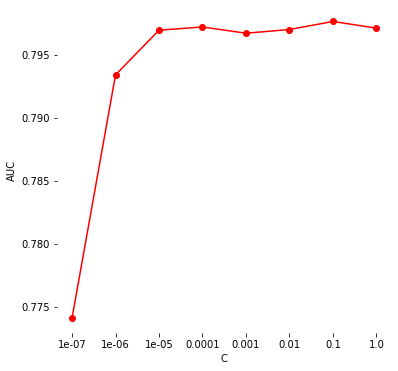

LogisticRegression(C=0.1, class_weight={0.0: 0.35, 1.0: 0.65}, n_jobs=-1) 0.7976524314197566


In [13]:
from sklearn.model_selection import train_test_split
X_tr, X_valid, y_tr,y_valid = train_test_split(X_train,y_train,train_size = 0.85, random_state = 42)

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf
grid = {
    'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression(class_weight = {1.0: 0.65, 0.0: 0.35}), paramGrid,
           X_tr, y_tr, X_valid, y_valid, 
           metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)



In [18]:
logmodel = LogisticRegression(class_weight = {1.0: 0.65, 0.0: 0.35}, C = 0.1, penalty = 'l2')
logmodel.fit(X_tr, y_tr)


LogisticRegression(C=0.1, class_weight={0.0: 0.35, 1.0: 0.65})

In [22]:
import pickle
model_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
export_path = os.path.join(model_path,'Best_Logistic.csv')
# to save the model
pickle.dump(logmodel, open(export_path, 'wb'))

# to load the saved model
logmodel = pickle.load(open(export_path, 'rb'))

Save outcomes for further use

In [19]:
import_path = os.path.join(path,'test_data.csv')
test_data = pd.read_csv(import_path, converters={'COLUMN_NAME': pd.eval})
test_data = test_data.set_index('id')

X_test = add_tfidf_features(test_data, word2tfidf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice.


In [32]:
y_test = y_test1.filter(items= X_test.index, axis=0)
print(X_test.shape, y_test.shape)

from sklearn.metrics import accuracy_score, log_loss

y_pred_test = logmodel.predict(X_test)
#predicted_y=np.argmax(y_pred_test,axis=1)
accuracy_score(y_test, y_pred_test)

(60640, 228) (60640,)


0.7051286279683378

In [33]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import numpy as np

print ('Accuracy:  ', accuracy_score(y_test, y_pred_test))
print ('F1 score:  ', f1_score(y_test, y_pred_test))
print ('Recall:    ', recall_score(y_test, y_pred_test))
print ('Precision: ', precision_score(y_test, y_pred_test))

print ('\nclasification report:\n\n', classification_report(y_test, y_pred_test))
print ('\n confusion matrix:\n\n',confusion_matrix(y_test, y_pred_test))

Accuracy:   0.7051286279683378
F1 score:   0.6666542383624467
Recall:     0.7968979810135045
Precision:  0.5730034610947314

clasification report:

               precision    recall  f1-score   support

           0       0.85      0.65      0.74     38203
           1       0.57      0.80      0.67     22437

    accuracy                           0.71     60640
   macro avg       0.71      0.72      0.70     60640
weighted avg       0.74      0.71      0.71     60640


 confusion matrix:

 [[24879 13324]
 [ 4557 17880]]


# Train with Linear SVM

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 10.2min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 10.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


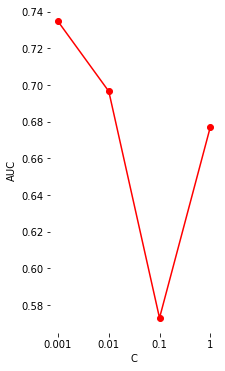

LinearSVC(C=0.001, class_weight={0.0: 0.35, 1.0: 0.65}, loss='hinge') 0.7347225077333278


In [ ]:
#linearSVC model - Included all features including distances and embeddings

from sklearn.model_selection import train_test_split
X_tr, X_valid, y_tr,y_valid = train_test_split(X_train,y_train,train_size = 0.85, random_state = 42)

from sklearn.svm import LinearSVC

grid = {
    'C': [0.001,0.01,0.1,1],
    'loss': ['hinge'],
    'penalty': ['l2']
}
paramGrid = ParameterGrid(grid)

linSVC_model, bestScore, allModels, allScores = pf.bestFit(LinearSVC(class_weight = {1.0: 0.65, 0.0:0.35}), paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score, scoreLabel = "AUC")

print(linSVC_model, bestScore)

In [24]:
from sklearn.svm import LinearSVC

linSVC= LinearSVC(class_weight = {1.0: 0.65, 0.0:0.35}, C = 0.001, loss = 'hinge')
linSVC.fit(X_test, y_test)

LinearSVC(C=0.001, class_weight={0.0: 0.35, 1.0: 0.65}, loss='hinge')

In [34]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_test = linSVC.predict(X_test)
#predicted_y=np.argmax(y_pred_test,axis=1)
accuracy_score(y_test, y_pred_test)

0.7129782321899736

In [35]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import numpy as np

print ('Accuracy:  ', accuracy_score(y_test, y_pred_test))
print ('F1 score:  ', f1_score(y_test, y_pred_test))
print ('Recall:    ', recall_score(y_test, y_pred_test))
print ('Precision: ', precision_score(y_test, y_pred_test))

print ('\nclasification report:\n\n', classification_report(y_test, y_pred_test))
print ('\n confusion matrix:\n\n',confusion_matrix(y_test, y_pred_test))

Accuracy:   0.7129782321899736
F1 score:   0.6676341971088663
Recall:     0.7791148549271293
Precision:  0.5840628132308721

clasification report:

               precision    recall  f1-score   support

           0       0.84      0.67      0.75     38203
           1       0.58      0.78      0.67     22437

    accuracy                           0.71     60640
   macro avg       0.71      0.73      0.71     60640
weighted avg       0.74      0.71      0.72     60640


 confusion matrix:

 [[25754 12449]
 [ 4956 17481]]


In [27]:
import pickle
model_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
export_path = os.path.join(model_path,'Best_SVC.csv')
# to save the model
pickle.dump(linSVC, open(export_path, 'wb'))

# to load the saved model
linSVC_model = pickle.load(open(export_path, 'rb'))

### LGBM Model

In [39]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import lightgbm as lgb
import pandas as pd
import sys
import os

In [ ]:
import_path = os.path.join(path,'test_data.csv')
test_data = pd.read_csv(import_path, converters={'COLUMN_NAME': pd.eval})
test_data = test_data.set_index('id')

X_test = add_tfidf_features(test_data, word2tfidf)

y_test = y_test1.filter(items= X_test.index, axis=0)
print(X_test.shape, y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice.


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_tr, X_valid, y_tr,y_valid = train_test_split(X_train,y_train,train_size = 0.85, random_state = 42)

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_train.save_binary('train.bin')
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# lightGMB hyperparameter tunning
learning_rate = [0.05, 0.1,0.2]  #default 0.1 [0.1, 0.2, 0.3, 0.4]
num_leaves = [500, 800, 1000, 1200, 1400]
boosting = ['gbdt']
max_depth =  [10] #[10,12,14]

resu=0.5
itr = 1
for lr in learning_rate:
        for nl in num_leaves:
            for md in max_depth:
              
                try:
                    
                    lgb_data = lgb.Dataset(X_tr, y_tr)
                    # specify your configurations as a dict
                    params = {'learning_rate':lr,'num_leaves':nl,'boosting':'gbdt','objective': 'binary',
                              'feature_fraction': 1,'bagging_fraction': bf, 'verbose': -1}
                    gmb = lgb.train(params, train_set=lgb_train, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
                    # predict the results
                    y_fitted=gmb.predict(X_valid)
                    acc = roc_auc_score(y_valid, y_fitted)
                    print(resu, acc)
                    if acc > resu:
                        resu=acc
                        print('>learning rate=', lr, 'num leaves = ', nl, 'max depth = ',md, 'bagging fraction = ', 0.6, 'resu = ', resu)
                except:
                    pass
        itr +=1
        print('iteration = ',itr)
print('~~~~~~~')

In [ ]:
#>learning rate= 0.1 num leaves =  100 max depth =  10 bagging fraction =  0.6 resu =  0.8938762147212838
#>learning rate= 0.05 num leaves =  800 max depth =  10 bagging fraction =  0.6 resu =  0.904597058749846
#>learning rate= 0.2 num leaves =  800 max depth =  10 bagging fraction =  0.6 resu =  0.9155575062815807
#>learning rate= 0.2 num leaves =  1000 max depth =  10 bagging fraction =  0.6 resu =  0.9159924543535031

In [41]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
X_tr, X_valid, y_tr,y_valid = train_test_split(X_train,y_train,train_size = 0.85, random_state = 42)

#loading data
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_train.save_binary('train.bin')
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# fitting the model
params = {'learning_rate':0.2,'num_leaves':800,'boosting':'gbdt','objective': 'binary', 'max_depth': 10,
                              'feature_fraction': 1,'bagging_fraction': 0.6, 'verbose': -1}
gmb_best = lgb.train(params, train_set=lgb_train, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)



In [42]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_test = gmb_best.predict(X_test)
y_pred_test = np.round(y_pred_test)
#predicted_y=np.argmax(y_pred_test,axis=1)
accuracy_score(y_test, y_pred_test)

0.8236147757255937

In [45]:
import pickle
model_path = "/content/drive/MyDrive/Copy-CDS-B3/Capstone/FAST API/Final"
export_path = os.path.join(model_path,'Best_LGBM.csv')
# to save the model
#pickle.dump(gmb_best, open(export_path, 'wb'))

# to load the saved model
lgbm_model = pickle.load(open(export_path, 'rb'))

In [46]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_test = lgbm_model.predict(X_test)
y_pred_test = np.round(y_pred_test)
#predicted_y=np.argmax(y_pred_test,axis=1)
accuracy_score(y_test, y_pred_test)

0.8236147757255937

In [47]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import numpy as np

print ('Accuracy:  ', accuracy_score(y_test, y_pred_test))
print ('F1 score:  ', f1_score(y_test, y_pred_test))
print ('Recall:    ', recall_score(y_test, y_pred_test))
print ('Precision: ', precision_score(y_test, y_pred_test))

print ('\nclasification report:\n\n', classification_report(y_test, y_pred_test))
print ('\n confusion matrix:\n\n',confusion_matrix(y_test, y_pred_test))

Accuracy:   0.8236147757255937
F1 score:   0.7602331315848464
Recall:     0.7557605740517894
Precision:  0.7647589410544355

clasification report:

               precision    recall  f1-score   support

           0       0.86      0.86      0.86     38203
           1       0.76      0.76      0.76     22437

    accuracy                           0.82     60640
   macro avg       0.81      0.81      0.81     60640
weighted avg       0.82      0.82      0.82     60640


 confusion matrix:

 [[32987  5216]
 [ 5480 16957]]


### Random Forest Classifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

paramgrid = {
    'max_depth': [4,6,8,10],
    'max_features': [2,4,6,8],
    'min_samples_leaf': [4,8,12],
    'n_estimators': [50,100,150]
}

rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train,y_train)


In [67]:
cv = RandomizedSearchCV(estimator = rnd_clf, param_distributions = paramgrid, cv = 5, n_jobs = -1)
cv.fit(X_train, y_train)
print(cv.best_params_)

{'n_estimators': 150, 'min_samples_leaf': 8, 'max_features': 8, 'max_depth': 8}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

paramgrid = {
    'max_depth': [8],
    'max_features': [10, 15, 20],
    'min_samples_leaf': [8],
    'n_estimators': [150, 200, 250]
}

rnd_clf = RandomForestClassifier()
cv_1 = RandomizedSearchCV(estimator = rnd_clf, param_distributions = paramgrid, cv = 5, n_jobs = -1)
cv_1.fit(X_train, y_train)
print(cv.best_params_)


NameError: ignored

In [69]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_test = cv.predict(X_test)
y_pred_test = np.round(y_pred_test)
#predicted_y=np.argmax(y_pred_test,axis=1)
accuracy_score(y_test, y_pred_test)

0.7334597625329815

In [70]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import numpy as np

print ('Accuracy:  ', accuracy_score(y_test, y_pred_test))
print ('F1 score:  ', f1_score(y_test, y_pred_test))
print ('Recall:    ', recall_score(y_test, y_pred_test))
print ('Precision: ', precision_score(y_test, y_pred_test))

print ('\nclasification report:\n\n', classification_report(y_test, y_pred_test))
print ('\n confusion matrix:\n\n',confusion_matrix(y_test, y_pred_test))

Accuracy:   0.7334597625329815
F1 score:   0.6189858796350864
Recall:     0.5851495297945358
Precision:  0.6569755804643715

clasification report:

               precision    recall  f1-score   support

           0       0.77      0.82      0.80     38203
           1       0.66      0.59      0.62     22437

    accuracy                           0.73     60640
   macro avg       0.71      0.70      0.71     60640
weighted avg       0.73      0.73      0.73     60640


 confusion matrix:

 [[31348  6855]
 [ 9308 13129]]


### Voting Classifier

In [48]:
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

In [ ]:
y_pred = vot_soft.predict(X_test)

In [53]:
estimator

[('LR', LogisticRegression(C=0.1, class_weight={0.0: 0.35, 1.0: 0.65})),
 LinearSVC(C=0.001, class_weight={0.0: 0.35, 1.0: 0.65}, loss='hinge'),
 XGBClassifier(colsample_bytree=0.5, learning_rate=0.3, max_depth=8,
               n_estimators=350, n_jobs=-1, nthread=2, random_state=25,
               reg_alpha=5, sub_sample=0.7)]

In [58]:
X_tr.shape, y_tr.shape

((292080, 228), (292080,))

In [63]:
from sklearn.ensemble import RandomForestClassifier

log_clf = LogisticRegression(C=0.1, class_weight={0.0: 0.35, 1.0: 0.65})
lin_clf = LinearSVC(class_weight = {1.0: 0.65, 0.0:0.35}, C = 0.001, loss = 'hinge')
xgb_clf = xgb.XGBClassifier(random_state=25,max_depth=8,n_estimators= 
                        350, reg_lambda = 1, learning_rate = 0.3, colsample_bytree=0.5, sub_sample = 0.7, nthread = 2, reg_alpha = 5)
#rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('svc', lin_clf), ('xgb', xgb_clf)], voting = 'hard')
voting_clf.fit(X_tr, y_tr)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1,
                                                 class_weight={0.0: 0.35,
                                                               1.0: 0.65})),
                             ('svc',
                              LinearSVC(C=0.001,
                                        class_weight={0.0: 0.35, 1.0: 0.65},
                                        loss='hinge')),
                             ('xgb',
                              XGBClassifier(colsample_bytree=0.5,
                                            learning_rate=0.3, max_depth=8,
                                            n_estimators=350, nthread=2,
                                            random_state=25, reg_alpha=5,
                                            sub_sample=0.7))])

In [64]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_test = voting_clf.predict(X_test)
y_pred_test = np.round(y_pred_test)
#predicted_y=np.argmax(y_pred_test,axis=1)
accuracy_score(y_test, y_pred_test)



0.7265171503957784